In [16]:
# from torchsr.datasets import Div2K
# from torchsr.models import ninasr_b0
from utils.training_utils import BabySINE, ImageDataset, pixel_coordinates_normalized, plot_image, list_png_files, load_image
from torch.utils.data import DataLoader
from tqdm import tqdm
import numpy as np
import torch
import os
import itertools
import matplotlib.pyplot as plt

# Autoreload
%reload_ext autoreload
%autoreload 2

# Div2K dataset
# dataset = Div2K(root="./data", scale=2, download=False)

In [17]:
# List all PNG files in the data folder
data_folder = "data"
image_files = list_png_files(data_folder)
print(f"Available PNG files: {image_files}")

Available PNG files: ['0010.png', '0028.png', '0002.png']


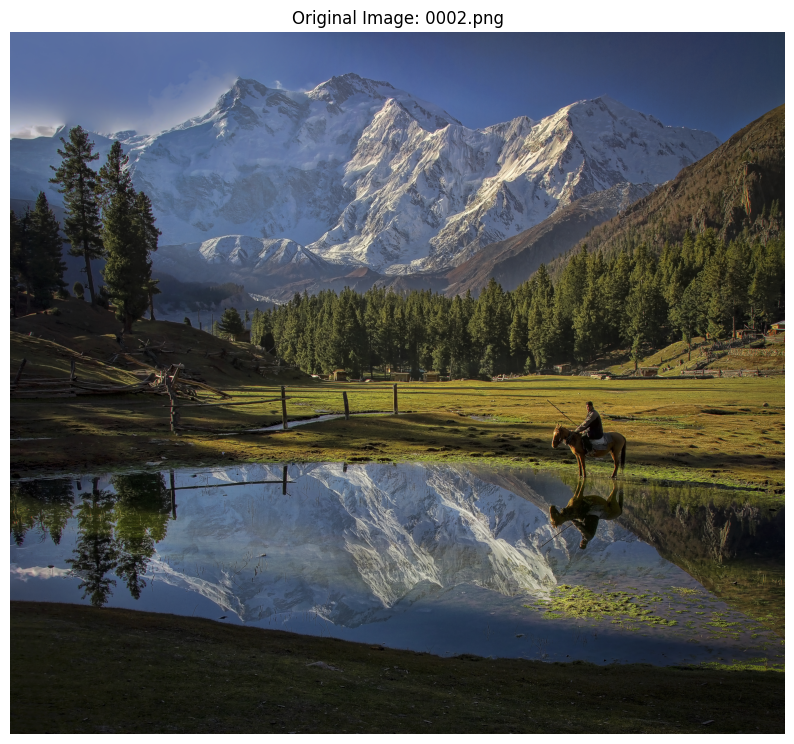

Image dimensions: 1848x2040, 3 channels


In [18]:
img_file_path = image_files[-1]
img_np_original, height_target, width_target, channels = load_image(data_folder, img_file_path)

The original image has shape: (1848, 2040, 3)
The downsampled image has shape: (231, 255, 3)


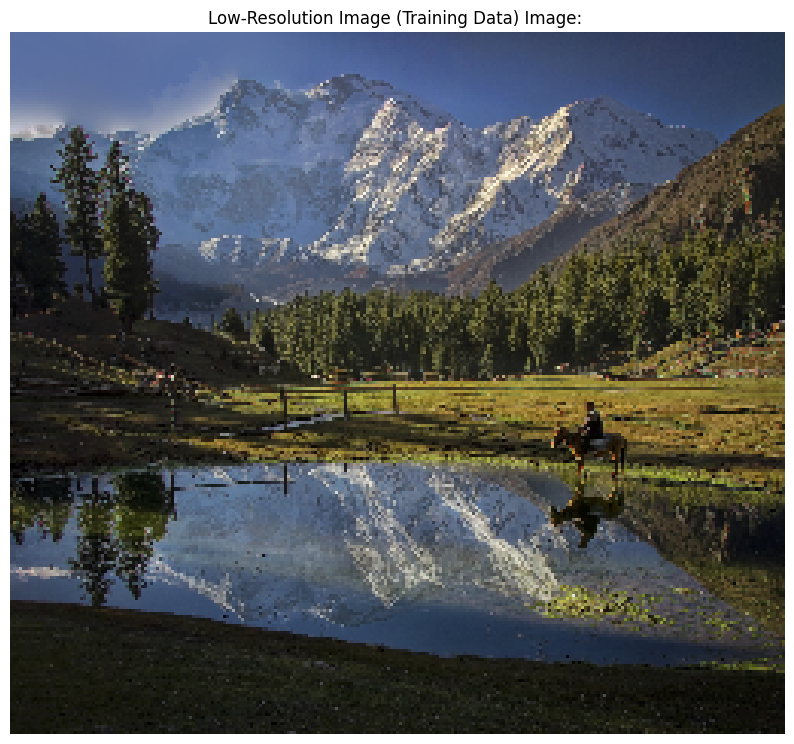

Image dimensions: 231x255, 3 channels


In [19]:
# Downsample the image and generate coordinates and pixel values
downsize_factor = 8 # Now we can use non-integer downsize factors
(
    low_res_coords, 
    low_res_pixel_values, 
    high_res_coords, 
    high_res_pixel_values, 
    low_res_shape, 
    high_res_shape
) = pixel_coordinates_normalized(img_np_original, downsize_factor)

# Reshape the low-resolution pixel values to the image shape
low_res_image = low_res_pixel_values.reshape(low_res_shape[0], low_res_shape[1], 3)

# Plot the low-resolution image
plot_image(low_res_image, "Low-Resolution Image (Training Data)")

In [20]:
# max and min of low_res_pixel_values
print("Low res pixel values max:", low_res_pixel_values.max())
print("Low res pixel values min:", low_res_pixel_values.min())

Low res pixel values max: 0.996078431372549
Low res pixel values min: 0.0


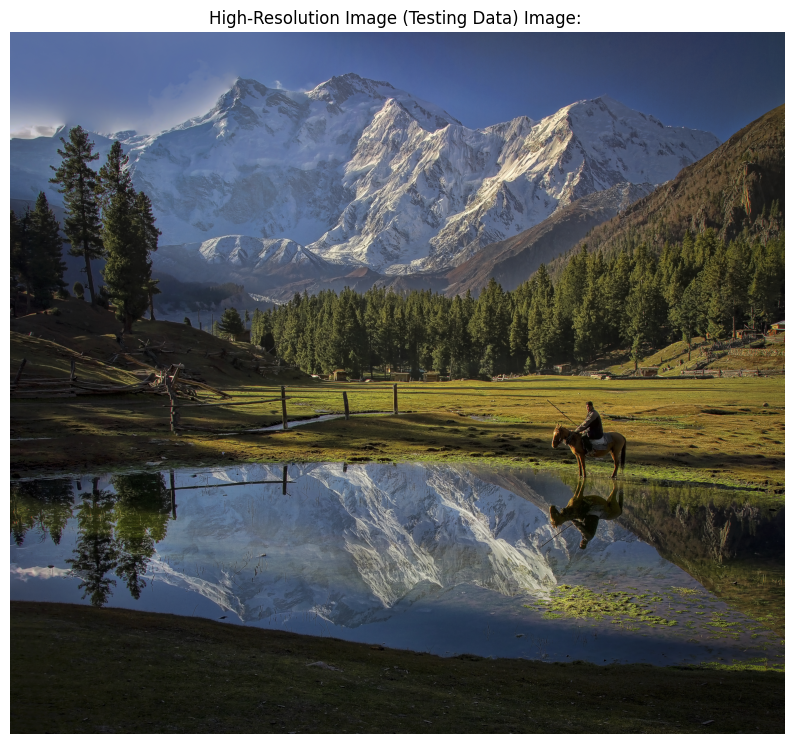

Image dimensions: 1848x2040, 3 channels


In [21]:
# Plot the original high res image

high_res_image = high_res_pixel_values.reshape(high_res_shape[0], high_res_shape[1], 3)
plot_image(high_res_image, "High-Resolution Image (Testing Data)")

In [22]:
# Create dataset and dataloader
dataset = ImageDataset(low_res_coords, low_res_pixel_values)
dataloader = DataLoader(dataset, batch_size=4096, shuffle=True)

In [23]:
# Initialize the model
device = torch.device("mps" if torch.backends.mps.is_available() else "cuda" if torch.cuda.is_available() else "cpu")
model = BabySINE(sigma=10.0, omega_0=15, num_layers=4, hidden_dim = 512).to(device)

In [24]:
# Train the model
losses, scheduler_values = model.train_model(
    dataloader,
    num_epochs=200,
    lr=1e-4,
    sigma=10.0,
)

Using device: mps


  0%|          | 1/200 [00:00<00:59,  3.35it/s]

Learning rate: 0.0001
Epoch 0, Loss: 0.237663
Epoch 0: Predicted pixel values range: 0.3894917964935303, 0.5962221026420593


 26%|██▌       | 51/200 [00:11<00:31,  4.74it/s]

Learning rate: 5e-05


 50%|█████     | 100/200 [00:22<00:22,  4.40it/s]

Learning rate: 2.5e-05


 50%|█████     | 101/200 [00:22<00:21,  4.51it/s]

Epoch 100, Loss: 0.007936
Epoch 100: Predicted pixel values range: 0.021516771987080574, 0.9182550311088562


 76%|███████▌  | 151/200 [00:33<00:10,  4.88it/s]

Learning rate: 1.25e-05


100%|██████████| 200/200 [00:44<00:00,  4.52it/s]

Learning rate: 6.25e-06


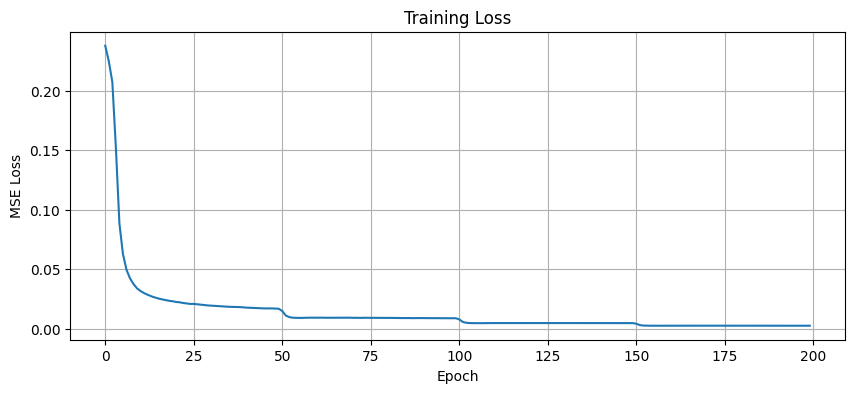

In [25]:
# Plot the loss curve
plt.figure(figsize=(10, 4))
plt.plot(losses)
plt.title("Training Loss")
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.grid(True)
plt.show()

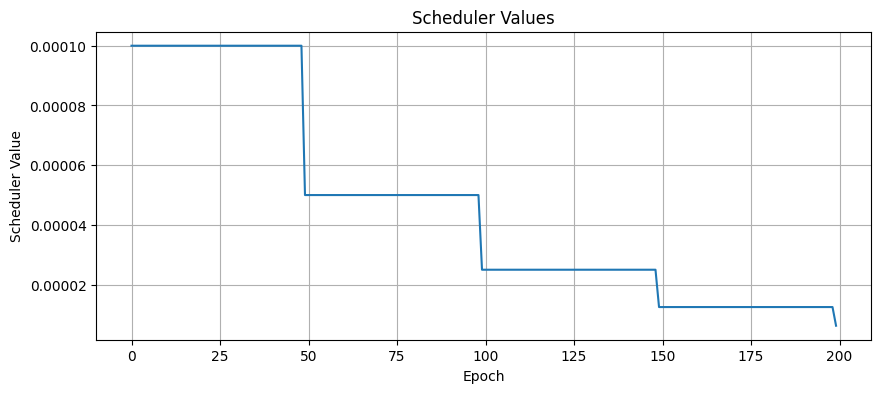

In [26]:
# Plot the scheduler values
plt.figure(figsize=(10, 4))
plt.plot(scheduler_values)
plt.title("Scheduler Values")
plt.xlabel("Epoch")
plt.ylabel("Scheduler Value")
plt.grid(True)
plt.show()

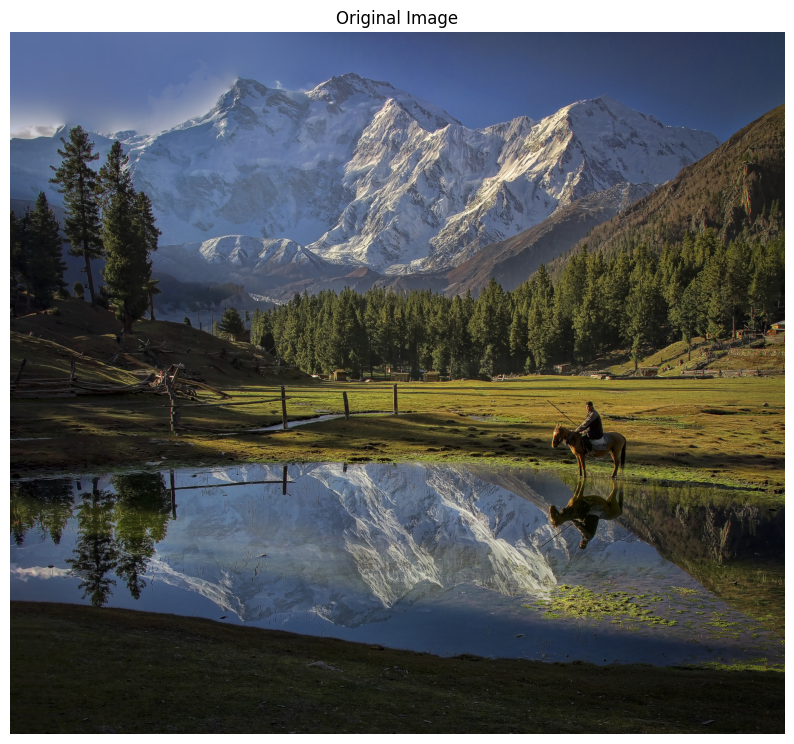

Image shape: (1848, 2040, 3)


In [27]:
# Plot the original Image
plt.figure(figsize=(10, 10))
plt.imshow(img_np_original)
plt.title("Original Image")
plt.axis("off")
plt.show()
print(f"Image shape: {img_np_original.shape}")

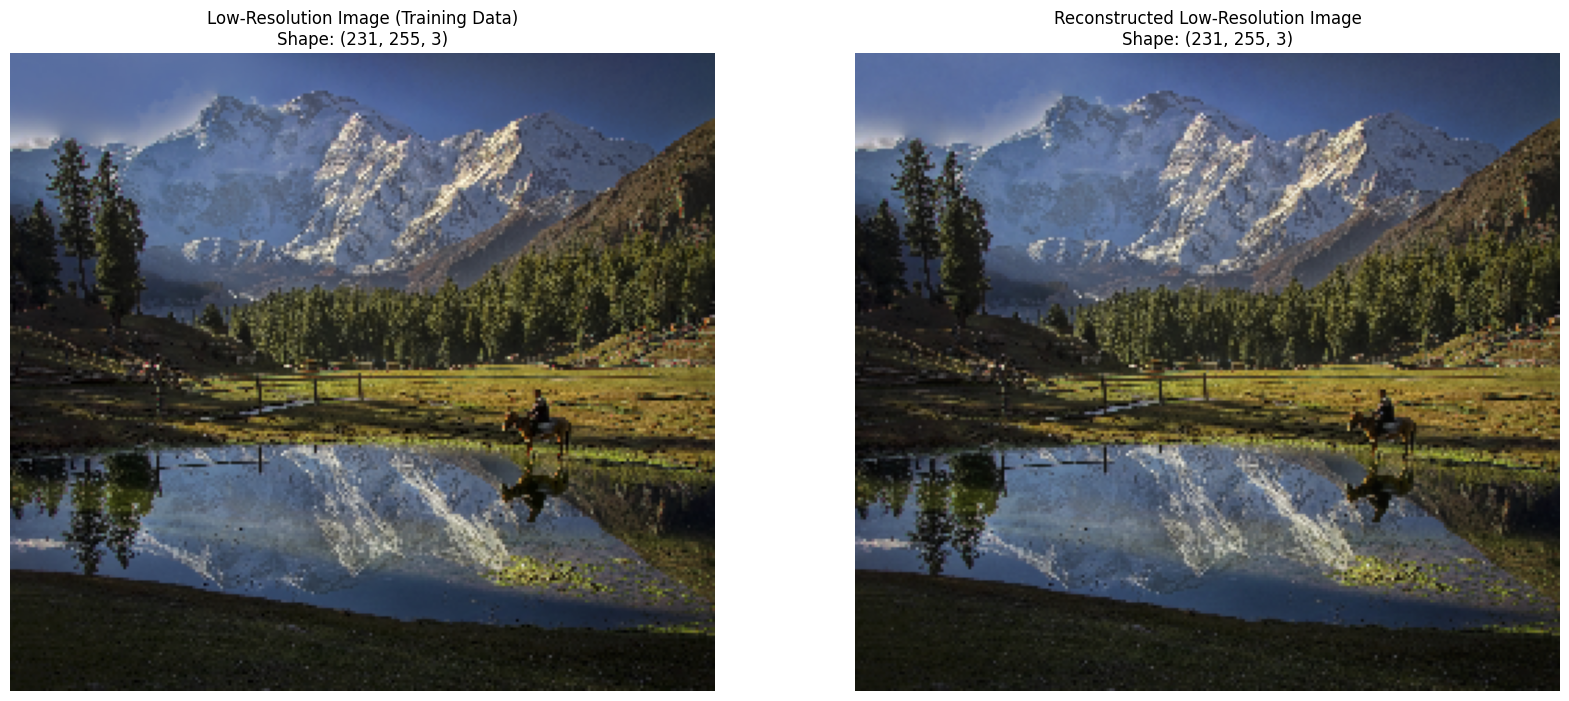

In [28]:
# Reconstruct the low-resolution image (learned during training)
target_coords_tensor_lr = torch.from_numpy(low_res_coords).float().to(device)
with torch.no_grad():
    pred_pixels_lr = model(target_coords_tensor_lr).cpu().numpy()

# Reshape and denormalize the predicted pixels for the low-resolution image
reconstructed_img_lr_normalized = pred_pixels_lr.reshape(low_res_shape[0], low_res_shape[1], 3)

# reconstructed_img_lr_denormalized = (reconstructed_img_lr_normalized * 255).astype(np.uint8)
# reconstructed_img_lr_denormalized = np.clip(reconstructed_img_lr_denormalized, 0, 255)

# Plot the reconstructed low-resolution image side by side with the training low res image
plt.figure(figsize=(20, 15))
plt.subplot(1, 2, 1)
plt.imshow(low_res_image)
plt.title(f"Low-Resolution Image (Training Data)\nShape: {low_res_image.shape}")
plt.axis("off")
plt.subplot(1, 2, 2)
plt.imshow(reconstructed_img_lr_normalized)
plt.title(f"Reconstructed Low-Resolution Image\nShape: {reconstructed_img_lr_normalized.shape}")
plt.axis("off")
plt.show()

In [14]:
def cross_validate_baby_sine(
    coordinates, 
    pixel_values, 
    batch_size=4096, 
    param_grid=None, 
    device=None
):
    """
    Perform cross-validation to find the best hyperparameters for BabySINE based on training loss.
    
    Args:
        coordinates (np.ndarray): Input coordinates (low-resolution).
        pixel_values (np.ndarray): Target pixel values (low-resolution).
        batch_size (int): Batch size for training.
        param_grid (dict): Dictionary of hyperparameters to search.
        device (torch.device): Device to use for training (CPU, CUDA, or MPS).
    
    Returns:
        dict: Best hyperparameters and their corresponding training loss.
    """
    if device is None:
        device = torch.device(
            "mps" if torch.backends.mps.is_available() else
            "cuda" if torch.cuda.is_available() else
            "cpu"
        )
    print(f"Using device: {device}")
    
    # Create dataset and dataloader
    dataset = ImageDataset(coordinates, pixel_values)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
    
    # Default parameter grid if none is provided
    if param_grid is None:
        param_grid = {
            "hidden_dim": [256, 512],
            "num_layers": [4, 5],
            "lr": [1e-4, 5e-4, 1e-3],
            "num_epochs": [50, 100, 200],
        }
    
    # Generate all combinations of hyperparameters
    param_combinations = list(itertools.product(
        param_grid["hidden_dim"],
        param_grid["num_layers"],
        param_grid["lr"],
        param_grid["num_epochs"]
    ))
    
    best_params = None
    best_train_loss = float("inf")
    all_losses = []  # Store losses for all parameter combinations
    param_labels = []  # Store parameter labels for plotting
    
    # Iterate over all parameter combinations with tqdm
    for params in tqdm(param_combinations, desc="Hyperparameter Combinations"):
        hidden_dim, num_layers, lr, num_epochs = params
        print(f"Testing params: hidden_dim={hidden_dim}, num_layers={num_layers}, lr={lr}, num_epochs={num_epochs}")
        
        # Initialize the model
        model = BabySINE(
            input_dim=2,
            output_dim=3,
            hidden_dim=hidden_dim,
            num_layers=num_layers
        ).to(device)
        
        # Train the model using the existing train_model function
        losses, _ = model.train_model(
            dataloader=dataloader,
            num_epochs=num_epochs,
            lr=lr,
            device=device,
            criterion=torch.nn.L1Loss(),
            sigma=10.0,
            scheduler_step_size=50,
            scheduler_gamma=0.5
        )
        
        # Get the final training loss
        final_train_loss = losses[-1]
        print(f"Final Training Loss: {final_train_loss:.6f}")
        
        # Store losses and parameter labels for plotting
        all_losses.append(losses)
        param_labels.append(f"hd={hidden_dim}, nl={num_layers}, lr={lr}, ep={num_epochs}")
        
        # Update best parameters if training loss improves
        if final_train_loss < best_train_loss:
            best_train_loss = final_train_loss
            best_params = {
                "hidden_dim": hidden_dim,
                "num_layers": num_layers,
                "lr": lr,
                "num_epochs": num_epochs,
                "train_loss": final_train_loss
            }
    
    # Plot the training losses for all parameter combinations
    plt.figure(figsize=(12, 8))
    for i, losses in enumerate(all_losses):
        plt.plot(losses, label=param_labels[i])
    plt.xlabel("Epochs")
    plt.ylabel("Training Loss")
    plt.title("Training Loss for Different Hyperparameter Combinations")
    plt.legend(loc="upper right", fontsize="small")
    plt.grid(True)
    plt.show()
    
    print(f"Best Parameters: {best_params}")
    return best_params

The original image has shape: (1848, 2040, 3)
The downsampled image has shape: (231, 255, 3)
Using device: mps


Hyperparameter Combinations:   0%|          | 0/36 [00:00<?, ?it/s]

Testing params: hidden_dim=256, num_layers=4, lr=0.0001, num_epochs=50
Using device: mps


Learning rate: 0.0001
Epoch 0, Loss: 0.235704
Epoch 0: Predicted pixel values range: 0.40804827213287354, 0.5690460801124573


Hyperparameter Combinations:   3%|▎         | 1/36 [00:10<05:57, 10.22s/it]

Learning rate: 5e-05
Final Training Loss: 0.023002
Testing params: hidden_dim=256, num_layers=4, lr=0.0001, num_epochs=100
Using device: mps


Learning rate: 0.0001
Epoch 0, Loss: 0.235985
Epoch 0: Predicted pixel values range: 0.41393521428108215, 0.5783832669258118


Learning rate: 5e-05


Hyperparameter Combinations:   6%|▌         | 2/36 [00:31<09:18, 16.44s/it]

Learning rate: 2.5e-05
Final Training Loss: 0.013722
Testing params: hidden_dim=256, num_layers=4, lr=0.0001, num_epochs=200
Using device: mps


Learning rate: 0.0001
Epoch 0, Loss: 0.235689
Epoch 0: Predicted pixel values range: 0.4015581011772156, 0.574932336807251


Learning rate: 5e-05


Learning rate: 2.5e-05
Epoch 100, Loss: 0.012515
Epoch 100: Predicted pixel values range: 0.02693486399948597, 0.9121160507202148


Learning rate: 1.25e-05


Hyperparameter Combinations:   8%|▊         | 3/36 [01:11<15:05, 27.45s/it]

Learning rate: 6.25e-06
Final Training Loss: 0.007965
Testing params: hidden_dim=256, num_layers=4, lr=0.0005, num_epochs=50
Using device: mps


Learning rate: 0.0005
Epoch 0, Loss: 0.194412
Epoch 0: Predicted pixel values range: 0.1759675145149231, 0.6627771854400635


Hyperparameter Combinations:  11%|█         | 4/36 [01:22<11:05, 20.79s/it]

Learning rate: 0.00025
Final Training Loss: 0.036947
Testing params: hidden_dim=256, num_layers=4, lr=0.0005, num_epochs=100
Using device: mps


Learning rate: 0.0005
Epoch 0, Loss: 0.196077
Epoch 0: Predicted pixel values range: 0.18240882456302643, 0.7208055257797241


Learning rate: 0.00025


Hyperparameter Combinations:  14%|█▍        | 5/36 [01:42<10:36, 20.54s/it]

Learning rate: 0.000125
Final Training Loss: 0.022761
Testing params: hidden_dim=256, num_layers=4, lr=0.0005, num_epochs=200
Using device: mps


Learning rate: 0.0005
Epoch 0, Loss: 0.196191
Epoch 0: Predicted pixel values range: 0.17805545032024384, 0.7387640476226807


Learning rate: 0.00025


Learning rate: 0.000125
Epoch 100, Loss: 0.019847
Epoch 100: Predicted pixel values range: 0.029909325763583183, 0.874828577041626


Learning rate: 6.25e-05


Hyperparameter Combinations:  17%|█▋        | 6/36 [02:22<13:32, 27.09s/it]

Learning rate: 3.125e-05
Final Training Loss: 0.008780
Testing params: hidden_dim=256, num_layers=4, lr=0.001, num_epochs=50
Using device: mps


Learning rate: 0.001
Epoch 0, Loss: 0.179479
Epoch 0: Predicted pixel values range: 0.13288439810276031, 0.6688488125801086


Hyperparameter Combinations:  19%|█▉        | 7/36 [02:31<10:22, 21.47s/it]

Learning rate: 0.0005
Final Training Loss: 0.069960
Testing params: hidden_dim=256, num_layers=4, lr=0.001, num_epochs=100
Using device: mps


Learning rate: 0.001
Epoch 0, Loss: 0.181996
Epoch 0: Predicted pixel values range: 0.16113990545272827, 0.6963450312614441


Learning rate: 0.0005


Hyperparameter Combinations:  22%|██▏       | 8/36 [02:52<09:48, 21.03s/it]

Learning rate: 0.00025
Final Training Loss: 0.036014
Testing params: hidden_dim=256, num_layers=4, lr=0.001, num_epochs=200
Using device: mps


Learning rate: 0.001
Epoch 0, Loss: 0.172686
Epoch 0: Predicted pixel values range: 0.1009860634803772, 0.7145659923553467


Learning rate: 0.0005


Learning rate: 0.00025


Epoch 100, Loss: 0.032577
Epoch 100: Predicted pixel values range: 0.042566318064928055, 0.8489055037498474


Learning rate: 0.000125


Hyperparameter Combinations:  25%|██▌       | 9/36 [03:32<12:10, 27.04s/it]

Learning rate: 6.25e-05
Final Training Loss: 0.012101
Testing params: hidden_dim=256, num_layers=5, lr=0.0001, num_epochs=50
Using device: mps


Learning rate: 0.0001
Epoch 0, Loss: 0.229584
Epoch 0: Predicted pixel values range: 0.36636000871658325, 0.6208354234695435


Hyperparameter Combinations:  28%|██▊       | 10/36 [03:42<09:29, 21.90s/it]

Learning rate: 5e-05
Final Training Loss: 0.019313
Testing params: hidden_dim=256, num_layers=5, lr=0.0001, num_epochs=100
Using device: mps


Learning rate: 0.0001
Epoch 0, Loss: 0.230732
Epoch 0: Predicted pixel values range: 0.3756241798400879, 0.5977663397789001


  2%|▏         | 2/100 [00:00<00:19,  4.92it/s]

Learning rate: 5e-05


Hyperparameter Combinations:  31%|███       | 11/36 [04:04<09:03, 21.76s/it]

Learning rate: 2.5e-05
Final Training Loss: 0.011623
Testing params: hidden_dim=256, num_layers=5, lr=0.0001, num_epochs=200
Using device: mps


Learning rate: 0.0001
Epoch 0, Loss: 0.230088
Epoch 0: Predicted pixel values range: 0.37983816862106323, 0.5982540845870972


Learning rate: 5e-05


Learning rate: 2.5e-05


Epoch 100, Loss: 0.011220
Epoch 100: Predicted pixel values range: 0.03224418684840202, 0.9120396971702576


Learning rate: 1.25e-05


Hyperparameter Combinations:  33%|███▎      | 12/36 [04:45<11:08, 27.86s/it]

Learning rate: 6.25e-06
Final Training Loss: 0.005805
Testing params: hidden_dim=256, num_layers=5, lr=0.0005, num_epochs=50
Using device: mps


Learning rate: 0.0005
Epoch 0, Loss: 0.186277
Epoch 0: Predicted pixel values range: 0.20054011046886444, 0.6373752355575562


Hyperparameter Combinations:  36%|███▌      | 13/36 [04:56<08:40, 22.61s/it]

Learning rate: 0.00025
Final Training Loss: 0.040936
Testing params: hidden_dim=256, num_layers=5, lr=0.0005, num_epochs=100
Using device: mps


Learning rate: 0.0005
Epoch 0, Loss: 0.186325
Epoch 0: Predicted pixel values range: 0.19698278605937958, 0.6406583189964294


Learning rate: 0.00025


Hyperparameter Combinations:  39%|███▉      | 14/36 [05:18<08:11, 22.34s/it]

Learning rate: 0.000125
Final Training Loss: 0.018990
Testing params: hidden_dim=256, num_layers=5, lr=0.0005, num_epochs=200
Using device: mps


Learning rate: 0.0005
Epoch 0, Loss: 0.180866
Epoch 0: Predicted pixel values range: 0.18184225261211395, 0.7321921586990356


Learning rate: 0.00025


Learning rate: 0.000125
Epoch 100, Loss: 0.016739
Epoch 100: Predicted pixel values range: 0.04266909882426262, 0.851749062538147


Learning rate: 6.25e-05


Hyperparameter Combinations:  42%|████▏     | 15/36 [05:59<09:49, 28.09s/it]

Learning rate: 3.125e-05
Final Training Loss: 0.006681
Testing params: hidden_dim=256, num_layers=5, lr=0.001, num_epochs=50
Using device: mps


Learning rate: 0.001
Epoch 0, Loss: 0.177643
Epoch 0: Predicted pixel values range: 0.12985655665397644, 0.7291479706764221


Hyperparameter Combinations:  44%|████▍     | 16/36 [06:10<07:36, 22.84s/it]

Learning rate: 0.0005
Final Training Loss: 0.116438
Testing params: hidden_dim=256, num_layers=5, lr=0.001, num_epochs=100
Using device: mps


Learning rate: 0.001
Epoch 0, Loss: 0.179186
Epoch 0: Predicted pixel values range: 0.12300474941730499, 0.6782201528549194


Learning rate: 0.0005


Hyperparameter Combinations:  47%|████▋     | 17/36 [06:31<07:05, 22.39s/it]

Learning rate: 0.00025
Final Training Loss: 0.149355
Testing params: hidden_dim=256, num_layers=5, lr=0.001, num_epochs=200
Using device: mps


Learning rate: 0.001
Epoch 0, Loss: 0.181083
Epoch 0: Predicted pixel values range: 0.14572758972644806, 0.7012627720832825


Learning rate: 0.0005


Learning rate: 0.00025
Epoch 100, Loss: 0.149427
Epoch 100: Predicted pixel values range: 0.20471413433551788, 0.3601749837398529


Learning rate: 0.000125


Hyperparameter Combinations:  50%|█████     | 18/36 [07:13<08:27, 28.18s/it]

Learning rate: 6.25e-05
Final Training Loss: 0.148881
Testing params: hidden_dim=512, num_layers=4, lr=0.0001, num_epochs=50
Using device: mps


Learning rate: 0.0001
Epoch 0, Loss: 0.233827
Epoch 0: Predicted pixel values range: 0.3364233672618866, 0.6439622640609741


Hyperparameter Combinations:  53%|█████▎    | 19/36 [07:23<06:30, 22.94s/it]

Learning rate: 5e-05
Final Training Loss: 0.015015
Testing params: hidden_dim=512, num_layers=4, lr=0.0001, num_epochs=100
Using device: mps


Learning rate: 0.0001
Epoch 0, Loss: 0.233849
Epoch 0: Predicted pixel values range: 0.3356647789478302, 0.6633385419845581


  2%|▏         | 2/100 [00:00<00:19,  5.05it/s]

Learning rate: 5e-05


Hyperparameter Combinations:  56%|█████▌    | 20/36 [07:45<05:59, 22.49s/it]

Learning rate: 2.5e-05
Final Training Loss: 0.007710
Testing params: hidden_dim=512, num_layers=4, lr=0.0001, num_epochs=200
Using device: mps


Learning rate: 0.0001
Epoch 0, Loss: 0.233001
Epoch 0: Predicted pixel values range: 0.3340567946434021, 0.6603362560272217


Learning rate: 5e-05


Learning rate: 2.5e-05


Epoch 100, Loss: 0.006852
Epoch 100: Predicted pixel values range: 0.023226642981171608, 0.875322163105011


Learning rate: 1.25e-05


Hyperparameter Combinations:  58%|█████▊    | 21/36 [08:28<07:10, 28.68s/it]

Learning rate: 6.25e-06
Final Training Loss: 0.002200
Testing params: hidden_dim=512, num_layers=4, lr=0.0005, num_epochs=50
Using device: mps


Learning rate: 0.0005
Epoch 0, Loss: 0.196373
Epoch 0: Predicted pixel values range: 0.11725796014070511, 0.8234402537345886


Hyperparameter Combinations:  61%|██████    | 22/36 [08:39<05:26, 23.31s/it]

Learning rate: 0.00025
Final Training Loss: 0.041719
Testing params: hidden_dim=512, num_layers=4, lr=0.0005, num_epochs=100
Using device: mps


Learning rate: 0.0005
Epoch 0, Loss: 0.200619
Epoch 0: Predicted pixel values range: 0.12307141721248627, 0.8133181929588318


Learning rate: 0.00025


Hyperparameter Combinations:  64%|██████▍   | 23/36 [09:00<04:55, 22.77s/it]

Learning rate: 0.000125
Final Training Loss: 0.016405
Testing params: hidden_dim=512, num_layers=4, lr=0.0005, num_epochs=200
Using device: mps


Learning rate: 0.0005
Epoch 0, Loss: 0.198098
Epoch 0: Predicted pixel values range: 0.11215753108263016, 0.8362348675727844


Learning rate: 0.00025


Learning rate: 0.000125
Epoch 100, Loss: 0.014576
Epoch 100: Predicted pixel values range: 0.03995317593216896, 0.867281973361969


 50%|█████     | 101/200 [00:21<00:21,  4.59it/s]

Learning rate: 6.25e-05


Hyperparameter Combinations:  67%|██████▋   | 24/36 [09:43<05:46, 28.87s/it]

Learning rate: 3.125e-05
Final Training Loss: 0.004623
Testing params: hidden_dim=512, num_layers=4, lr=0.001, num_epochs=50
Using device: mps


Learning rate: 0.001
Epoch 0, Loss: 0.196821
Epoch 0: Predicted pixel values range: 0.12410759180784225, 0.8552963733673096


Hyperparameter Combinations:  69%|██████▉   | 25/36 [09:54<04:17, 23.44s/it]

Learning rate: 0.0005
Final Training Loss: 0.151876
Testing params: hidden_dim=512, num_layers=4, lr=0.001, num_epochs=100
Using device: mps


Learning rate: 0.001
Epoch 0, Loss: 0.199121
Epoch 0: Predicted pixel values range: 0.12224764376878738, 0.8131176829338074


Learning rate: 0.0005


Hyperparameter Combinations:  72%|███████▏  | 26/36 [10:16<03:48, 22.82s/it]

Learning rate: 0.00025
Final Training Loss: 0.149757
Testing params: hidden_dim=512, num_layers=4, lr=0.001, num_epochs=200
Using device: mps


Learning rate: 0.001
Epoch 0, Loss: 0.199384
Epoch 0: Predicted pixel values range: 0.12125484645366669, 0.7627437114715576


Learning rate: 0.0005


Learning rate: 0.00025


Epoch 100, Loss: 0.149302
Epoch 100: Predicted pixel values range: 0.18849153816699982, 0.38521188497543335


Learning rate: 0.000125


Hyperparameter Combinations:  75%|███████▌  | 27/36 [10:59<04:20, 28.90s/it]

Learning rate: 6.25e-05
Final Training Loss: 0.041917
Testing params: hidden_dim=512, num_layers=5, lr=0.0001, num_epochs=50
Using device: mps


Learning rate: 0.0001
Epoch 0, Loss: 0.223595
Epoch 0: Predicted pixel values range: 0.30836284160614014, 0.6849261522293091


Hyperparameter Combinations:  78%|███████▊  | 28/36 [11:10<03:08, 23.60s/it]

Learning rate: 5e-05
Final Training Loss: 0.014991
Testing params: hidden_dim=512, num_layers=5, lr=0.0001, num_epochs=100
Using device: mps


Learning rate: 0.0001
Epoch 0, Loss: 0.224756
Epoch 0: Predicted pixel values range: 0.3068044185638428, 0.6978335976600647


Learning rate: 5e-05


Hyperparameter Combinations:  81%|████████  | 29/36 [11:32<02:43, 23.29s/it]

Learning rate: 2.5e-05
Final Training Loss: 0.007886
Testing params: hidden_dim=512, num_layers=5, lr=0.0001, num_epochs=200
Using device: mps


Learning rate: 0.0001
Epoch 0, Loss: 0.224946
Epoch 0: Predicted pixel values range: 0.3000001013278961, 0.6793510317802429


Learning rate: 5e-05


Learning rate: 2.5e-05


Epoch 100, Loss: 0.007239
Epoch 100: Predicted pixel values range: 0.031038768589496613, 0.9123675227165222


Learning rate: 1.25e-05


Hyperparameter Combinations:  83%|████████▎ | 30/36 [12:18<03:00, 30.02s/it]

Learning rate: 6.25e-06
Final Training Loss: 0.002322
Testing params: hidden_dim=512, num_layers=5, lr=0.0005, num_epochs=50
Using device: mps


Learning rate: 0.0005
Epoch 0, Loss: 0.190404
Epoch 0: Predicted pixel values range: 0.14430153369903564, 0.7901850938796997


Hyperparameter Combinations:  86%|████████▌ | 31/36 [12:30<02:02, 24.49s/it]

Learning rate: 0.00025
Final Training Loss: 0.078125
Testing params: hidden_dim=512, num_layers=5, lr=0.0005, num_epochs=100
Using device: mps


Learning rate: 0.0005
Epoch 0, Loss: 0.195457
Epoch 0: Predicted pixel values range: 0.16834285855293274, 0.7855468392372131


Learning rate: 0.00025


Hyperparameter Combinations:  89%|████████▉ | 32/36 [12:52<01:35, 23.86s/it]

Learning rate: 0.000125
Final Training Loss: 0.052636
Testing params: hidden_dim=512, num_layers=5, lr=0.0005, num_epochs=200
Using device: mps


Learning rate: 0.0005
Epoch 0, Loss: 0.194831
Epoch 0: Predicted pixel values range: 0.1633070707321167, 0.7732195854187012


Learning rate: 0.00025


Learning rate: 0.000125


Epoch 100, Loss: 0.048926
Epoch 100: Predicted pixel values range: 0.05616086348891258, 0.6738811135292053


Learning rate: 6.25e-05


Hyperparameter Combinations:  92%|█████████▏| 33/36 [13:37<01:30, 30.14s/it]

Learning rate: 3.125e-05
Final Training Loss: 0.009402
Testing params: hidden_dim=512, num_layers=5, lr=0.001, num_epochs=50
Using device: mps


Learning rate: 0.001
Epoch 0, Loss: 0.212882
Epoch 0: Predicted pixel values range: 0.19351403415203094, 0.7696726322174072


Hyperparameter Combinations:  94%|█████████▍| 34/36 [13:48<00:48, 24.44s/it]

Learning rate: 0.0005
Final Training Loss: 0.152153
Testing params: hidden_dim=512, num_layers=5, lr=0.001, num_epochs=100
Using device: mps


Learning rate: 0.001
Epoch 0, Loss: 0.205679
Epoch 0: Predicted pixel values range: 0.14139601588249207, 0.7275739908218384


Learning rate: 0.0005


Hyperparameter Combinations:  97%|█████████▋| 35/36 [14:10<00:23, 23.79s/it]

Learning rate: 0.00025
Final Training Loss: 0.149588
Testing params: hidden_dim=512, num_layers=5, lr=0.001, num_epochs=200
Using device: mps


Learning rate: 0.001
Epoch 0, Loss: 0.210287
Epoch 0: Predicted pixel values range: 0.1478545069694519, 0.756733238697052


Learning rate: 0.0005


Learning rate: 0.00025


Epoch 100, Loss: 0.149919
Epoch 100: Predicted pixel values range: 0.19220654666423798, 0.39346441626548767


Learning rate: 0.000125


Hyperparameter Combinations: 100%|██████████| 36/36 [14:56<00:00, 24.91s/it]

Learning rate: 6.25e-05
Final Training Loss: 0.148885


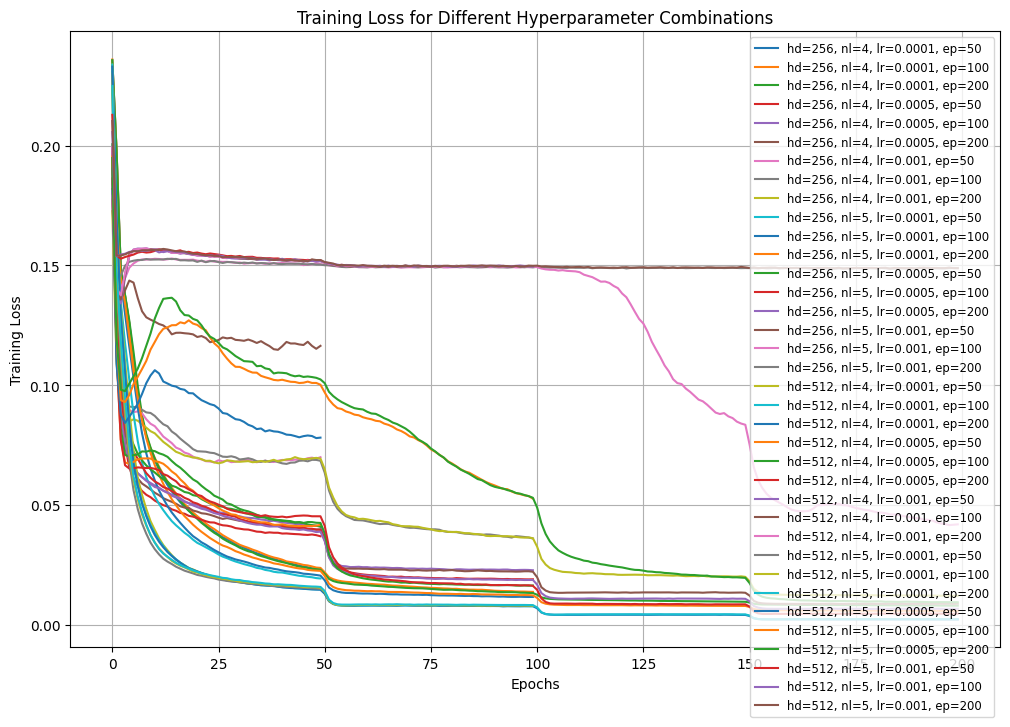

Best Parameters: {'hidden_dim': 512, 'num_layers': 4, 'lr': 0.0001, 'num_epochs': 200, 'train_loss': 0.0022004399293412765}


In [15]:
# Generate low-resolution data
low_res_coords, low_res_pixel_values, _, _, _, _ = pixel_coordinates_normalized(img_np_original, downsize_factor=8)

# Perform cross-validation
best_params = cross_validate_baby_sine(
    coordinates=low_res_coords,
    pixel_values=low_res_pixel_values,
    batch_size=4096,
    param_grid=None
)